Will implement cointegration arbitrage strategy using Johansen Test (Pairs Trading). Eigenvalues are very small theefore this pair is not the best. Will update later.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt
import yfinance as yf

In [14]:
start_date = '2020-01-01'
KO = yf.download('KO', start=start_date)['Close']
PEP = yf.download('PEP', start=start_date)['Close']

data = pd.DataFrame({'Coca-Cola': KO, 'Pepsi': PEP})

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [15]:
data.head(5)

,Coca-Cola,Pepsi
Date,,
2020-01-02,54.990002,135.820007
2020-01-03,54.689999,135.630005
2020-01-06,54.669998,136.149994
2020-01-07,54.250000,134.009995
2020-01-08,54.349998,134.699997


In [16]:
def johansen_test(data, det_order=-1, k_ar_diff=1):
    result = coint_johansen(data, det_order, k_ar_diff)
    return result

johansen_result = johansen_test(data)
print("Eigenvalues:", johansen_result.eig)
print("Critical values:", johansen_result.cvt)

Eigenvalues: [7.32757397e-03 4.79145737e-05]
Critical values: [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]


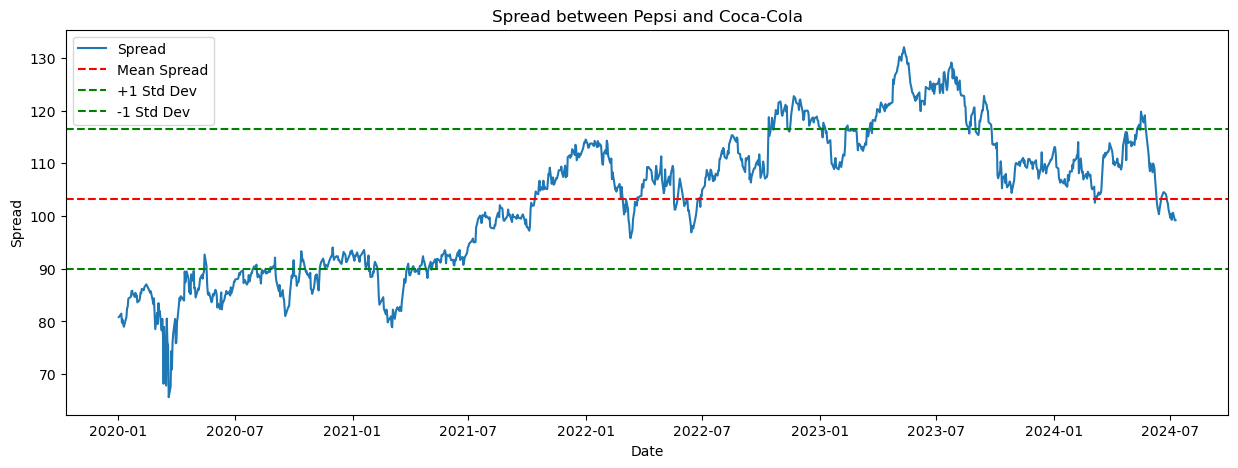

In [18]:
data['Spread'] = data['Pepsi'] - data['Coca-Cola']
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['Spread'], label='Spread')
plt.axhline(data['Spread'].mean(), color='red', linestyle='--', label='Mean Spread')
plt.axhline(data['Spread'].mean() + data['Spread'].std(), color='green', linestyle='--', label='+1 Std Dev')
plt.axhline(data['Spread'].mean() - data['Spread'].std(), color='green', linestyle='--', label='-1 Std Dev')
plt.title('Spread between Pepsi and Coca-Cola')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [19]:
mean_spread = data['Spread'].mean()
std_spread = data['Spread'].std()
data['Signal'] = 0
data.loc[data['Spread'] > mean_spread + std_spread, 'Signal'] = -1 
data.loc[data['Spread'] < mean_spread - std_spread, 'Signal'] = 1 

In [21]:
data['Position'] = data['Signal'].shift()
data.dropna(inplace=True)
data['Returns'] = data['Pepsi'].pct_change()
data['Strategy'] = data['Position'] * data['Returns']
data['Cumulative Market Returns'] = (1 + data['Returns']).cumprod() - 1
data['Cumulative Strategy Returns'] = (1 + data['Strategy']).cumprod() - 1

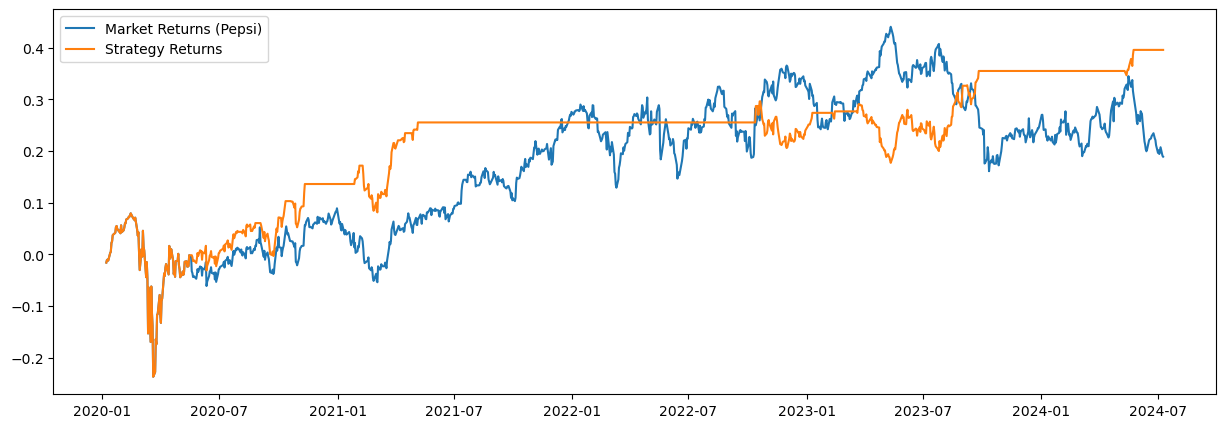

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(data['Cumulative Market Returns'], label='Market Returns (Pepsi)')
plt.plot(data['Cumulative Strategy Returns'], label='Strategy Returns')
plt.legend()
plt.show()

In [23]:
def evaluate_performance(data):
    total_return = data['Cumulative Strategy Returns'].iloc[-1]
    annualized_return = ((1 + total_return) ** (252.0 / len(data))) - 1
    annualized_volatility = data['Strategy'].std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    print(f"Total Return: {total_return:.2f}")
    print(f"Annualized Return: {annualized_return:.2f}")
    print(f"Annualized Volatility: {annualized_volatility:.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

evaluate_performance(data)

Total Return: 0.40
Annualized Return: 0.08
Annualized Volatility: 0.18
Sharpe Ratio: 0.42
